In [1]:
# GUIDELINE
# 1 funcao que testa tudo.

# deveria haver um alinhamento completo das estruturas de dados

# mas nao adianta se eu nao souber o problema que eu quero resolver.

# OBJETIVO - score de presenca. Quantos porcento de produto que tem na prateleira.


# Historico
- Rede dupla e/ou com 100 neuronios: ruim. Nos primeiros passos o resultado fica razoavel, mas quando avanca piora.
- Rede unica com 10 neuronios: bom.

In [1]:
#https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
import sys 
import json
import numpy as np # linear algebra
import matplotlib.pyplot as plt # this is used for the plot the graph 
import math
import collections
import pandas as pd

## for Deep-learing:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.models import model_from_json
from tensorflow.python.keras.callbacks import TensorBoard

from itertools import product
from functools import partial
from time import time

from core.DataExploration import DataExploration
from core.ModelIndicators import ModelIndicators
from ruptura.CreateBatch import CreateBatch
from ruptura.RupturaPrediction import RupturaPrediction
from ruptura.RupturaNeuralNetwork import RupturaNeuralNetwork

Using TensorFlow backend.


In [2]:
version = '0-1-0'
referenceDate = '1/03/2019'
modelName = 'model-' + version

# CARREGAMENTO DOS DADOS

In [3]:
createBatch = CreateBatch(version)
X, Y, Ytest, lastX = createBatch.batch('barbieri-ymod.json', (60,3)) # Tem que resolver esse warning

WARNING - need error handling on samples


# MODEL DEFINITION

In [6]:
batch_size = 64
weightVector = [1,0.1] # posso abaixar esse numero
time_steps = X.shape[1]
x_dimension = X.shape[2]
y_dimension = Y.shape[2]
if len(weightVector) != y_dimension:
    raise Exception('custom loss weights is not defined correctly')

rupNN = RupturaNeuralNetwork(modelName)
newModel = False

if newModel:
    n_neurons = 12
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    model.add(TimeDistributed(Dense(y_dimension, activation='softmax')))
    #model.add(LSTM(n_neurons, input_shape=(time_steps, x_dimension), return_sequences=True)) 
    #model.add(TimeDistributed(Dense(x_dimension, activation='softmax')))
    model.compile(
        loss=rupNN.getCustomLoss((batch_size,time_steps), weightVector),
        optimizer='adam')
    print('MODEL CREATED\n')
    print(model.summary())
else:
    model = rupNN.loadModel((batch_size,time_steps), weightVector)  # Y dimensions are needed for custom loss definitions
    print('MODEL LOADED\n')
    print(model.summary())

MODEL LOADED

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 12)            768       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 60, 2)             26        
Total params: 794
Trainable params: 794
Non-trainable params: 0
_________________________________________________________________
None


# TRAINING

In [24]:
cut1 = batch_size
cut2 = X.shape[0] - X.shape[0]%batch_size
Xval, Xtrain,_ = np.split(X,[cut1,cut2])
Yval, Ytrain,_ = np.split(Y,[cut1,cut2])
for step in range(30):
    n_epoch = 100
    model.fit(Xtrain, Ytrain, 
                  epochs=n_epoch, 
                  batch_size= batch_size, 
                  validation_data=(Xval, Yval),
                  verbose=2)
    rupNN.saveModel(model)

Train on 3008 samples, validate on 64 samples
Epoch 1/100
 - 9s - loss: 0.1591 - val_loss: 0.1551
Epoch 2/100
 - 7s - loss: 0.1482 - val_loss: 0.1488
Epoch 3/100
 - 7s - loss: 0.1421 - val_loss: 0.1455
Epoch 4/100
 - 8s - loss: 0.1393 - val_loss: 0.1426
Epoch 5/100
 - 10s - loss: 0.1369 - val_loss: 0.1390
Epoch 6/100
 - 10s - loss: 0.1342 - val_loss: 0.1355
Epoch 7/100
 - 9s - loss: 0.1311 - val_loss: 0.1314
Epoch 8/100
 - 9s - loss: 0.1283 - val_loss: 0.1276
Epoch 9/100
 - 9s - loss: 0.1255 - val_loss: 0.1256
Epoch 10/100
 - 8s - loss: 0.1230 - val_loss: 0.1241
Epoch 11/100
 - 7s - loss: 0.1205 - val_loss: 0.1237
Epoch 12/100
 - 9s - loss: 0.1187 - val_loss: 0.1234
Epoch 13/100
 - 9s - loss: 0.1175 - val_loss: 0.1233
Epoch 14/100
 - 9s - loss: 0.1166 - val_loss: 0.1225
Epoch 15/100
 - 9s - loss: 0.1159 - val_loss: 0.1225
Epoch 16/100
 - 9s - loss: 0.1153 - val_loss: 0.1220
Epoch 17/100
 - 9s - loss: 0.1149 - val_loss: 0.1213
Epoch 18/100
 - 9s - loss: 0.1143 - val_loss: 0.1209
Epoch 1

Epoch 54/100
 - 9s - loss: 0.0878 - val_loss: 0.0919
Epoch 55/100
 - 9s - loss: 0.0873 - val_loss: 0.0916
Epoch 56/100
 - 8s - loss: 0.0872 - val_loss: 0.0920
Epoch 57/100
 - 9s - loss: 0.0871 - val_loss: 0.0915
Epoch 58/100
 - 8s - loss: 0.0868 - val_loss: 0.0931
Epoch 59/100
 - 8s - loss: 0.0867 - val_loss: 0.0913
Epoch 60/100
 - 9s - loss: 0.0865 - val_loss: 0.0913
Epoch 61/100
 - 8s - loss: 0.0861 - val_loss: 0.0916
Epoch 62/100
 - 8s - loss: 0.0863 - val_loss: 0.0917
Epoch 63/100
 - 9s - loss: 0.0859 - val_loss: 0.0909
Epoch 64/100
 - 9s - loss: 0.0856 - val_loss: 0.0910
Epoch 65/100
 - 8s - loss: 0.0858 - val_loss: 0.0920
Epoch 66/100
 - 9s - loss: 0.0853 - val_loss: 0.0901
Epoch 67/100
 - 9s - loss: 0.0851 - val_loss: 0.0904
Epoch 68/100
 - 9s - loss: 0.0855 - val_loss: 0.0902
Epoch 69/100
 - 9s - loss: 0.0852 - val_loss: 0.0904
Epoch 70/100
 - 9s - loss: 0.0851 - val_loss: 0.0905
Epoch 71/100
 - 9s - loss: 0.0850 - val_loss: 0.0923
Epoch 72/100
 - 9s - loss: 0.0846 - val_loss: 

Epoch 7/100
 - 9s - loss: 0.0731 - val_loss: 0.0760
Epoch 8/100
 - 9s - loss: 0.0733 - val_loss: 0.0794
Epoch 9/100
 - 9s - loss: 0.0737 - val_loss: 0.0751
Epoch 10/100
 - 9s - loss: 0.0731 - val_loss: 0.0764
Epoch 11/100
 - 9s - loss: 0.0734 - val_loss: 0.0748
Epoch 12/100
 - 9s - loss: 0.0730 - val_loss: 0.0757
Epoch 13/100
 - 9s - loss: 0.0728 - val_loss: 0.0749
Epoch 14/100
 - 9s - loss: 0.0730 - val_loss: 0.0753
Epoch 15/100
 - 8s - loss: 0.0728 - val_loss: 0.0782
Epoch 16/100
 - 9s - loss: 0.0728 - val_loss: 0.0745
Epoch 17/100
 - 9s - loss: 0.0728 - val_loss: 0.0748
Epoch 18/100
 - 9s - loss: 0.0728 - val_loss: 0.0751
Epoch 19/100
 - 9s - loss: 0.0727 - val_loss: 0.0754
Epoch 20/100
 - 8s - loss: 0.0726 - val_loss: 0.0742
Epoch 21/100
 - 8s - loss: 0.0726 - val_loss: 0.0747
Epoch 22/100
 - 10s - loss: 0.0726 - val_loss: 0.0744
Epoch 23/100
 - 10s - loss: 0.0723 - val_loss: 0.0744
Epoch 24/100
 - 10s - loss: 0.0724 - val_loss: 0.0740
Epoch 25/100
 - 10s - loss: 0.0725 - val_loss:

Epoch 61/100
 - 9s - loss: 0.0686 - val_loss: 0.0697
Epoch 62/100
 - 9s - loss: 0.0683 - val_loss: 0.0701
Epoch 63/100
 - 8s - loss: 0.0689 - val_loss: 0.0717
Epoch 64/100
 - 8s - loss: 0.0695 - val_loss: 0.0710
Epoch 65/100
 - 8s - loss: 0.0686 - val_loss: 0.0700
Epoch 66/100
 - 9s - loss: 0.0685 - val_loss: 0.0727
Epoch 67/100
 - 9s - loss: 0.0687 - val_loss: 0.0713
Epoch 68/100
 - 9s - loss: 0.0685 - val_loss: 0.0697
Epoch 69/100
 - 9s - loss: 0.0684 - val_loss: 0.0709
Epoch 70/100
 - 9s - loss: 0.0690 - val_loss: 0.0693
Epoch 71/100
 - 9s - loss: 0.0683 - val_loss: 0.0700
Epoch 72/100
 - 9s - loss: 0.0683 - val_loss: 0.0709
Epoch 73/100
 - 9s - loss: 0.0683 - val_loss: 0.0697
Epoch 74/100
 - 9s - loss: 0.0681 - val_loss: 0.0707
Epoch 75/100
 - 9s - loss: 0.0686 - val_loss: 0.0703
Epoch 76/100
 - 9s - loss: 0.0682 - val_loss: 0.0712
Epoch 77/100
 - 9s - loss: 0.0687 - val_loss: 0.0741
Epoch 78/100
 - 9s - loss: 0.0686 - val_loss: 0.0695
Epoch 79/100
 - 9s - loss: 0.0682 - val_loss: 

Epoch 14/100
 - 9s - loss: 0.0650 - val_loss: 0.0672
Epoch 15/100
 - 9s - loss: 0.0653 - val_loss: 0.0672
Epoch 16/100
 - 9s - loss: 0.0653 - val_loss: 0.0673
Epoch 17/100
 - 9s - loss: 0.0650 - val_loss: 0.0676
Epoch 18/100
 - 8s - loss: 0.0657 - val_loss: 0.0672
Epoch 19/100
 - 9s - loss: 0.0652 - val_loss: 0.0670
Epoch 20/100
 - 9s - loss: 0.0649 - val_loss: 0.0670
Epoch 21/100
 - 9s - loss: 0.0650 - val_loss: 0.0672
Epoch 22/100
 - 9s - loss: 0.0655 - val_loss: 0.0683
Epoch 23/100
 - 8s - loss: 0.0661 - val_loss: 0.0684
Epoch 24/100
 - 8s - loss: 0.0655 - val_loss: 0.0678
Epoch 25/100
 - 9s - loss: 0.0651 - val_loss: 0.0670
Epoch 26/100
 - 9s - loss: 0.0649 - val_loss: 0.0672
Epoch 27/100
 - 8s - loss: 0.0649 - val_loss: 0.0670
Epoch 28/100
 - 9s - loss: 0.0649 - val_loss: 0.0672
Epoch 29/100
 - 8s - loss: 0.0648 - val_loss: 0.0678
Epoch 30/100
 - 9s - loss: 0.0655 - val_loss: 0.0682
Epoch 31/100
 - 9s - loss: 0.0648 - val_loss: 0.0669
Epoch 32/100
 - 9s - loss: 0.0649 - val_loss: 

Epoch 68/100
 - 7s - loss: 0.0636 - val_loss: 0.0668
Epoch 69/100
 - 7s - loss: 0.0640 - val_loss: 0.0658
Epoch 70/100
 - 7s - loss: 0.0637 - val_loss: 0.0669
Epoch 71/100
 - 7s - loss: 0.0634 - val_loss: 0.0676
Epoch 72/100
 - 7s - loss: 0.0636 - val_loss: 0.0668
Epoch 73/100
 - 7s - loss: 0.0636 - val_loss: 0.0675
Epoch 74/100
 - 7s - loss: 0.0644 - val_loss: 0.0655
Epoch 75/100
 - 7s - loss: 0.0637 - val_loss: 0.0656
Epoch 76/100
 - 7s - loss: 0.0632 - val_loss: 0.0658
Epoch 77/100
 - 7s - loss: 0.0636 - val_loss: 0.0664
Epoch 78/100
 - 7s - loss: 0.0634 - val_loss: 0.0676
Epoch 79/100
 - 7s - loss: 0.0634 - val_loss: 0.0649
Epoch 80/100
 - 7s - loss: 0.0634 - val_loss: 0.0644
Epoch 81/100
 - 7s - loss: 0.0635 - val_loss: 0.0663
Epoch 82/100
 - 7s - loss: 0.0664 - val_loss: 0.0651
Epoch 83/100
 - 7s - loss: 0.0634 - val_loss: 0.0644
Epoch 84/100
 - 7s - loss: 0.0634 - val_loss: 0.0669
Epoch 85/100
 - 7s - loss: 0.0633 - val_loss: 0.0647
Epoch 86/100
 - 7s - loss: 0.0632 - val_loss: 

 - 7s - loss: 0.0631 - val_loss: 0.0633
Epoch 22/100
 - 7s - loss: 0.0621 - val_loss: 0.0641
Epoch 23/100
 - 7s - loss: 0.0626 - val_loss: 0.0635
Epoch 24/100
 - 7s - loss: 0.0629 - val_loss: 0.0650
Epoch 25/100
 - 7s - loss: 0.0627 - val_loss: 0.0649
Epoch 26/100
 - 7s - loss: 0.0623 - val_loss: 0.0635
Epoch 27/100
 - 7s - loss: 0.0620 - val_loss: 0.0648
Epoch 28/100
 - 7s - loss: 0.0619 - val_loss: 0.0642
Epoch 29/100
 - 7s - loss: 0.0627 - val_loss: 0.0661
Epoch 30/100
 - 7s - loss: 0.0631 - val_loss: 0.0662
Epoch 31/100
 - 7s - loss: 0.0623 - val_loss: 0.0634
Epoch 32/100
 - 7s - loss: 0.0623 - val_loss: 0.0655
Epoch 33/100
 - 7s - loss: 0.0629 - val_loss: 0.0637
Epoch 34/100
 - 7s - loss: 0.0621 - val_loss: 0.0656
Epoch 35/100
 - 7s - loss: 0.0621 - val_loss: 0.0642
Epoch 36/100
 - 7s - loss: 0.0620 - val_loss: 0.0632
Epoch 37/100
 - 7s - loss: 0.0621 - val_loss: 0.0639
Epoch 38/100
 - 7s - loss: 0.0620 - val_loss: 0.0632
Epoch 39/100
 - 7s - loss: 0.0621 - val_loss: 0.0636
Epoch 

 - 7s - loss: 0.0615 - val_loss: 0.0647
Epoch 76/100
 - 7s - loss: 0.0614 - val_loss: 0.0645
Epoch 77/100
 - 7s - loss: 0.0617 - val_loss: 0.0666
Epoch 78/100
 - 7s - loss: 0.0619 - val_loss: 0.0649
Epoch 79/100
 - 7s - loss: 0.0614 - val_loss: 0.0640
Epoch 80/100
 - 7s - loss: 0.0615 - val_loss: 0.0645
Epoch 81/100
 - 7s - loss: 0.0621 - val_loss: 0.0667
Epoch 82/100
 - 7s - loss: 0.0625 - val_loss: 0.0641
Epoch 83/100
 - 7s - loss: 0.0614 - val_loss: 0.0645
Epoch 84/100
 - 7s - loss: 0.0612 - val_loss: 0.0656
Epoch 85/100
 - 7s - loss: 0.0614 - val_loss: 0.0648
Epoch 86/100
 - 7s - loss: 0.0615 - val_loss: 0.0642
Epoch 87/100
 - 7s - loss: 0.0621 - val_loss: 0.0636
Epoch 88/100
 - 7s - loss: 0.0616 - val_loss: 0.0638
Epoch 89/100
 - 7s - loss: 0.0612 - val_loss: 0.0643
Epoch 90/100
 - 7s - loss: 0.0612 - val_loss: 0.0633
Epoch 91/100
 - 7s - loss: 0.0614 - val_loss: 0.0636
Epoch 92/100
 - 7s - loss: 0.0612 - val_loss: 0.0642
Epoch 93/100
 - 7s - loss: 0.0612 - val_loss: 0.0632
Epoch 

Epoch 29/100
 - 7s - loss: 0.0606 - val_loss: 0.0642
Epoch 30/100
 - 7s - loss: 0.0610 - val_loss: 0.0647
Epoch 31/100
 - 7s - loss: 0.0620 - val_loss: 0.0636
Epoch 32/100
 - 7s - loss: 0.0609 - val_loss: 0.0639
Epoch 33/100
 - 7s - loss: 0.0606 - val_loss: 0.0642
Epoch 34/100
 - 7s - loss: 0.0607 - val_loss: 0.0635
Epoch 35/100
 - 7s - loss: 0.0604 - val_loss: 0.0638
Epoch 36/100
 - 7s - loss: 0.0604 - val_loss: 0.0640
Epoch 37/100
 - 7s - loss: 0.0606 - val_loss: 0.0655
Epoch 38/100
 - 7s - loss: 0.0609 - val_loss: 0.0644
Epoch 39/100
 - 7s - loss: 0.0612 - val_loss: 0.0661
Epoch 40/100
 - 7s - loss: 0.0615 - val_loss: 0.0647
Epoch 41/100
 - 7s - loss: 0.0609 - val_loss: 0.0644
Epoch 42/100
 - 7s - loss: 0.0607 - val_loss: 0.0639
Epoch 43/100
 - 7s - loss: 0.0606 - val_loss: 0.0630
Epoch 44/100
 - 7s - loss: 0.0604 - val_loss: 0.0645
Epoch 45/100
 - 7s - loss: 0.0608 - val_loss: 0.0629
Epoch 46/100
 - 7s - loss: 0.0614 - val_loss: 0.0633
Epoch 47/100
 - 7s - loss: 0.0605 - val_loss: 

Epoch 83/100
 - 7s - loss: 0.0601 - val_loss: 0.0637
Epoch 84/100
 - 7s - loss: 0.0601 - val_loss: 0.0634
Epoch 85/100
 - 7s - loss: 0.0601 - val_loss: 0.0626
Epoch 86/100
 - 7s - loss: 0.0605 - val_loss: 0.0648
Epoch 87/100
 - 7s - loss: 0.0611 - val_loss: 0.0656
Epoch 88/100
 - 7s - loss: 0.0600 - val_loss: 0.0638
Epoch 89/100
 - 7s - loss: 0.0602 - val_loss: 0.0627
Epoch 90/100
 - 7s - loss: 0.0604 - val_loss: 0.0637
Epoch 91/100
 - 7s - loss: 0.0599 - val_loss: 0.0639
Epoch 92/100
 - 7s - loss: 0.0604 - val_loss: 0.0625
Epoch 93/100
 - 7s - loss: 0.0600 - val_loss: 0.0622
Epoch 94/100
 - 7s - loss: 0.0601 - val_loss: 0.0669
Epoch 95/100
 - 7s - loss: 0.0607 - val_loss: 0.0632
Epoch 96/100
 - 7s - loss: 0.0600 - val_loss: 0.0636
Epoch 97/100
 - 7s - loss: 0.0599 - val_loss: 0.0624
Epoch 98/100
 - 7s - loss: 0.0599 - val_loss: 0.0641
Epoch 99/100
 - 7s - loss: 0.0601 - val_loss: 0.0634
Epoch 100/100
 - 7s - loss: 0.0600 - val_loss: 0.0628
Train on 3008 samples, validate on 64 samples

 - 7s - loss: 0.0593 - val_loss: 0.0626
Epoch 37/100
 - 7s - loss: 0.0595 - val_loss: 0.0630
Epoch 38/100
 - 7s - loss: 0.0595 - val_loss: 0.0628
Epoch 39/100
 - 7s - loss: 0.0597 - val_loss: 0.0626
Epoch 40/100
 - 7s - loss: 0.0594 - val_loss: 0.0630
Epoch 41/100
 - 7s - loss: 0.0598 - val_loss: 0.0637
Epoch 42/100
 - 7s - loss: 0.0596 - val_loss: 0.0645
Epoch 43/100
 - 7s - loss: 0.0593 - val_loss: 0.0620
Epoch 44/100
 - 7s - loss: 0.0594 - val_loss: 0.0635
Epoch 45/100
 - 7s - loss: 0.0593 - val_loss: 0.0618
Epoch 46/100
 - 7s - loss: 0.0596 - val_loss: 0.0628
Epoch 47/100
 - 7s - loss: 0.0595 - val_loss: 0.0621
Epoch 48/100
 - 7s - loss: 0.0596 - val_loss: 0.0618
Epoch 49/100
 - 7s - loss: 0.0593 - val_loss: 0.0631
Epoch 50/100
 - 7s - loss: 0.0595 - val_loss: 0.0621
Epoch 51/100
 - 7s - loss: 0.0595 - val_loss: 0.0638
Epoch 52/100
 - 7s - loss: 0.0597 - val_loss: 0.0615
Epoch 53/100
 - 7s - loss: 0.0595 - val_loss: 0.0627
Epoch 54/100
 - 7s - loss: 0.0592 - val_loss: 0.0626
Epoch 

 - 7s - loss: 0.0589 - val_loss: 0.0619
Epoch 91/100
 - 7s - loss: 0.0593 - val_loss: 0.0619
Epoch 92/100
 - 7s - loss: 0.0595 - val_loss: 0.0639
Epoch 93/100
 - 7s - loss: 0.0593 - val_loss: 0.0624
Epoch 94/100
 - 7s - loss: 0.0588 - val_loss: 0.0610
Epoch 95/100
 - 7s - loss: 0.0588 - val_loss: 0.0627
Epoch 96/100
 - 7s - loss: 0.0586 - val_loss: 0.0619
Epoch 97/100
 - 7s - loss: 0.0588 - val_loss: 0.0620
Epoch 98/100
 - 7s - loss: 0.0588 - val_loss: 0.0625
Epoch 99/100
 - 7s - loss: 0.0589 - val_loss: 0.0632
Epoch 100/100
 - 7s - loss: 0.0586 - val_loss: 0.0616
Train on 3008 samples, validate on 64 samples
Epoch 1/100
 - 7s - loss: 0.0589 - val_loss: 0.0617
Epoch 2/100
 - 7s - loss: 0.0591 - val_loss: 0.0617
Epoch 3/100
 - 7s - loss: 0.0588 - val_loss: 0.0633
Epoch 4/100
 - 7s - loss: 0.0589 - val_loss: 0.0623
Epoch 5/100
 - 7s - loss: 0.0589 - val_loss: 0.0648
Epoch 6/100
 - 7s - loss: 0.0593 - val_loss: 0.0615
Epoch 7/100
 - 7s - loss: 0.0586 - val_loss: 0.0612
Epoch 8/100
 - 7s -

Epoch 44/100
 - 7s - loss: 0.0585 - val_loss: 0.0625
Epoch 45/100
 - 7s - loss: 0.0585 - val_loss: 0.0609
Epoch 46/100
 - 7s - loss: 0.0587 - val_loss: 0.0629
Epoch 47/100
 - 7s - loss: 0.0589 - val_loss: 0.0667
Epoch 48/100
 - 7s - loss: 0.0594 - val_loss: 0.0619
Epoch 49/100
 - 7s - loss: 0.0586 - val_loss: 0.0611
Epoch 50/100
 - 7s - loss: 0.0588 - val_loss: 0.0627
Epoch 51/100
 - 7s - loss: 0.0587 - val_loss: 0.0624
Epoch 52/100
 - 7s - loss: 0.0585 - val_loss: 0.0613
Epoch 53/100
 - 7s - loss: 0.0586 - val_loss: 0.0608
Epoch 54/100
 - 7s - loss: 0.0584 - val_loss: 0.0624
Epoch 55/100
 - 7s - loss: 0.0592 - val_loss: 0.0616
Epoch 56/100
 - 7s - loss: 0.0586 - val_loss: 0.0607
Epoch 57/100
 - 7s - loss: 0.0586 - val_loss: 0.0610
Epoch 58/100
 - 7s - loss: 0.0593 - val_loss: 0.0625
Epoch 59/100
 - 7s - loss: 0.0592 - val_loss: 0.0609
Epoch 60/100
 - 7s - loss: 0.0584 - val_loss: 0.0612
Epoch 61/100
 - 7s - loss: 0.0584 - val_loss: 0.0611
Epoch 62/100
 - 7s - loss: 0.0587 - val_loss: 

Epoch 98/100
 - 7s - loss: 0.0584 - val_loss: 0.0618
Epoch 99/100
 - 7s - loss: 0.0588 - val_loss: 0.0626
Epoch 100/100
 - 7s - loss: 0.0596 - val_loss: 0.0618
Train on 3008 samples, validate on 64 samples
Epoch 1/100
 - 7s - loss: 0.0586 - val_loss: 0.0607
Epoch 2/100
 - 7s - loss: 0.0586 - val_loss: 0.0616
Epoch 3/100
 - 7s - loss: 0.0583 - val_loss: 0.0617
Epoch 4/100
 - 7s - loss: 0.0584 - val_loss: 0.0609
Epoch 5/100
 - 7s - loss: 0.0584 - val_loss: 0.0605
Epoch 6/100
 - 7s - loss: 0.0581 - val_loss: 0.0621
Epoch 7/100
 - 7s - loss: 0.0582 - val_loss: 0.0614
Epoch 8/100
 - 7s - loss: 0.0583 - val_loss: 0.0607
Epoch 9/100
 - 7s - loss: 0.0580 - val_loss: 0.0608
Epoch 10/100
 - 7s - loss: 0.0579 - val_loss: 0.0620
Epoch 11/100
 - 7s - loss: 0.0587 - val_loss: 0.0629
Epoch 12/100
 - 7s - loss: 0.0588 - val_loss: 0.0621
Epoch 13/100
 - 7s - loss: 0.0587 - val_loss: 0.0620
Epoch 14/100
 - 7s - loss: 0.0592 - val_loss: 0.0616
Epoch 15/100
 - 7s - loss: 0.0585 - val_loss: 0.0627
Epoch 16

 - 7s - loss: 0.0581 - val_loss: 0.0609
Epoch 52/100
 - 7s - loss: 0.0579 - val_loss: 0.0603
Epoch 53/100
 - 7s - loss: 0.0576 - val_loss: 0.0605
Epoch 54/100
 - 7s - loss: 0.0580 - val_loss: 0.0610
Epoch 55/100
 - 7s - loss: 0.0591 - val_loss: 0.0638
Epoch 56/100
 - 7s - loss: 0.0591 - val_loss: 0.0612
Epoch 57/100
 - 7s - loss: 0.0579 - val_loss: 0.0608
Epoch 58/100
 - 7s - loss: 0.0578 - val_loss: 0.0606
Epoch 59/100
 - 7s - loss: 0.0578 - val_loss: 0.0613
Epoch 60/100
 - 7s - loss: 0.0580 - val_loss: 0.0605
Epoch 61/100
 - 7s - loss: 0.0587 - val_loss: 0.0606
Epoch 62/100
 - 7s - loss: 0.0582 - val_loss: 0.0610
Epoch 63/100
 - 7s - loss: 0.0578 - val_loss: 0.0604
Epoch 64/100
 - 7s - loss: 0.0583 - val_loss: 0.0620
Epoch 65/100
 - 7s - loss: 0.0590 - val_loss: 0.0610
Epoch 66/100
 - 7s - loss: 0.0578 - val_loss: 0.0601
Epoch 67/100
 - 7s - loss: 0.0579 - val_loss: 0.0604
Epoch 68/100
 - 7s - loss: 0.0580 - val_loss: 0.0603
Epoch 69/100
 - 7s - loss: 0.0580 - val_loss: 0.0606
Epoch 

Epoch 5/100
 - 7s - loss: 0.0596 - val_loss: 0.0617
Epoch 6/100
 - 7s - loss: 0.0586 - val_loss: 0.0605
Epoch 7/100
 - 7s - loss: 0.0574 - val_loss: 0.0599
Epoch 8/100
 - 7s - loss: 0.0576 - val_loss: 0.0624
Epoch 9/100
 - 7s - loss: 0.0584 - val_loss: 0.0601
Epoch 10/100
 - 7s - loss: 0.0576 - val_loss: 0.0600
Epoch 11/100
 - 7s - loss: 0.0577 - val_loss: 0.0601
Epoch 12/100
 - 7s - loss: 0.0579 - val_loss: 0.0599
Epoch 13/100
 - 7s - loss: 0.0587 - val_loss: 0.0643
Epoch 14/100
 - 7s - loss: 0.0658 - val_loss: 0.0614
Epoch 15/100
 - 7s - loss: 0.0581 - val_loss: 0.0603
Epoch 16/100
 - 7s - loss: 0.0574 - val_loss: 0.0607
Epoch 17/100
 - 7s - loss: 0.0575 - val_loss: 0.0598
Epoch 18/100
 - 7s - loss: 0.0575 - val_loss: 0.0602
Epoch 19/100
 - 7s - loss: 0.0573 - val_loss: 0.0602
Epoch 20/100
 - 7s - loss: 0.0573 - val_loss: 0.0602
Epoch 21/100
 - 7s - loss: 0.0575 - val_loss: 0.0615
Epoch 22/100
 - 7s - loss: 0.0583 - val_loss: 0.0605
Epoch 23/100
 - 7s - loss: 0.0577 - val_loss: 0.060

Epoch 59/100
 - 7s - loss: 0.0574 - val_loss: 0.0610
Epoch 60/100
 - 7s - loss: 0.0573 - val_loss: 0.0606
Epoch 61/100
 - 7s - loss: 0.0573 - val_loss: 0.0594
Epoch 62/100
 - 7s - loss: 0.0570 - val_loss: 0.0598
Epoch 63/100
 - 7s - loss: 0.0572 - val_loss: 0.0598
Epoch 64/100
 - 7s - loss: 0.0574 - val_loss: 0.0603
Epoch 65/100
 - 7s - loss: 0.0632 - val_loss: 0.0637
Epoch 66/100
 - 7s - loss: 0.0601 - val_loss: 0.0619
Epoch 67/100
 - 7s - loss: 0.0584 - val_loss: 0.0613
Epoch 68/100
 - 7s - loss: 0.0574 - val_loss: 0.0599
Epoch 69/100
 - 7s - loss: 0.0573 - val_loss: 0.0595
Epoch 70/100
 - 7s - loss: 0.0572 - val_loss: 0.0596
Epoch 71/100
 - 7s - loss: 0.0592 - val_loss: 0.0607
Epoch 72/100
 - 7s - loss: 0.0578 - val_loss: 0.0599
Epoch 73/100
 - 7s - loss: 0.0572 - val_loss: 0.0591
Epoch 74/100
 - 7s - loss: 0.0572 - val_loss: 0.0605
Epoch 75/100
 - 7s - loss: 0.0570 - val_loss: 0.0595
Epoch 76/100
 - 7s - loss: 0.0571 - val_loss: 0.0594
Epoch 77/100
 - 7s - loss: 0.0576 - val_loss: 

 - 7s - loss: 0.0573 - val_loss: 0.0595
Epoch 13/100
 - 7s - loss: 0.0569 - val_loss: 0.0597
Epoch 14/100
 - 7s - loss: 0.0568 - val_loss: 0.0592
Epoch 15/100
 - 7s - loss: 0.0567 - val_loss: 0.0588
Epoch 16/100
 - 7s - loss: 0.0567 - val_loss: 0.0591
Epoch 17/100
 - 7s - loss: 0.0568 - val_loss: 0.0618
Epoch 18/100
 - 7s - loss: 0.0568 - val_loss: 0.0597
Epoch 19/100
 - 7s - loss: 0.0581 - val_loss: 0.0603
Epoch 20/100
 - 7s - loss: 0.0575 - val_loss: 0.0597
Epoch 21/100
 - 7s - loss: 0.0578 - val_loss: 0.0638
Epoch 22/100
 - 7s - loss: 0.0588 - val_loss: 0.0609
Epoch 23/100
 - 7s - loss: 0.0568 - val_loss: 0.0593
Epoch 24/100
 - 7s - loss: 0.0569 - val_loss: 0.0593
Epoch 25/100
 - 7s - loss: 0.0567 - val_loss: 0.0601
Epoch 26/100
 - 7s - loss: 0.0569 - val_loss: 0.0593
Epoch 27/100
 - 7s - loss: 0.0571 - val_loss: 0.0602
Epoch 28/100
 - 7s - loss: 0.0567 - val_loss: 0.0602
Epoch 29/100
 - 7s - loss: 0.0569 - val_loss: 0.0590
Epoch 30/100
 - 7s - loss: 0.0566 - val_loss: 0.0589
Epoch 

 - 7s - loss: 0.0566 - val_loss: 0.0589
Epoch 67/100
 - 7s - loss: 0.0566 - val_loss: 0.0594
Epoch 68/100
 - 7s - loss: 0.0565 - val_loss: 0.0594
Epoch 69/100
 - 7s - loss: 0.0564 - val_loss: 0.0588
Epoch 70/100
 - 7s - loss: 0.0565 - val_loss: 0.0591
Epoch 71/100
 - 7s - loss: 0.0564 - val_loss: 0.0588
Epoch 72/100
 - 7s - loss: 0.0569 - val_loss: 0.0591
Epoch 73/100
 - 7s - loss: 0.0583 - val_loss: 0.0621
Epoch 74/100
 - 7s - loss: 0.0578 - val_loss: 0.0597
Epoch 75/100
 - 7s - loss: 0.0572 - val_loss: 0.0592
Epoch 76/100
 - 7s - loss: 0.0569 - val_loss: 0.0598
Epoch 77/100
 - 7s - loss: 0.0580 - val_loss: 0.0603
Epoch 78/100
 - 7s - loss: 0.0566 - val_loss: 0.0587
Epoch 79/100
 - 7s - loss: 0.0568 - val_loss: 0.0587
Epoch 80/100
 - 7s - loss: 0.0566 - val_loss: 0.0597
Epoch 81/100
 - 7s - loss: 0.0567 - val_loss: 0.0592
Epoch 82/100
 - 7s - loss: 0.0568 - val_loss: 0.0605
Epoch 83/100
 - 7s - loss: 0.0572 - val_loss: 0.0605
Epoch 84/100
 - 7s - loss: 0.0570 - val_loss: 0.0586
Epoch 

Epoch 20/100
 - 7s - loss: 0.0590 - val_loss: 0.0598
Epoch 21/100
 - 7s - loss: 0.0581 - val_loss: 0.0608
Epoch 22/100
 - 7s - loss: 0.0580 - val_loss: 0.0596
Epoch 23/100
 - 7s - loss: 0.0585 - val_loss: 0.0588
Epoch 24/100
 - 7s - loss: 0.0581 - val_loss: 0.0596
Epoch 25/100
 - 7s - loss: 0.0580 - val_loss: 0.0594
Epoch 26/100
 - 7s - loss: 0.0577 - val_loss: 0.0589
Epoch 27/100
 - 7s - loss: 0.0579 - val_loss: 0.0590
Epoch 28/100
 - 7s - loss: 0.0577 - val_loss: 0.0597
Epoch 29/100
 - 7s - loss: 0.0578 - val_loss: 0.0606
Epoch 30/100
 - 7s - loss: 0.0581 - val_loss: 0.0600
Epoch 31/100
 - 7s - loss: 0.0583 - val_loss: 0.0593
Epoch 32/100
 - 7s - loss: 0.0588 - val_loss: 0.0599
Epoch 33/100
 - 7s - loss: 0.0579 - val_loss: 0.0603
Epoch 34/100
 - 7s - loss: 0.0581 - val_loss: 0.0599
Epoch 35/100
 - 7s - loss: 0.0600 - val_loss: 0.0599
Epoch 36/100
 - 7s - loss: 0.0586 - val_loss: 0.0594
Epoch 37/100
 - 7s - loss: 0.0582 - val_loss: 0.0601
Epoch 38/100
 - 7s - loss: 0.0584 - val_loss: 

# VALIDATION

Contratos adimplentes:   229
Contratos inadimlentes:  2901
xAxis:   [0.0, 24.75, 49.5, 74.25, 99.0] 

yAxis:   [88, 90, 88, 90, 98] 



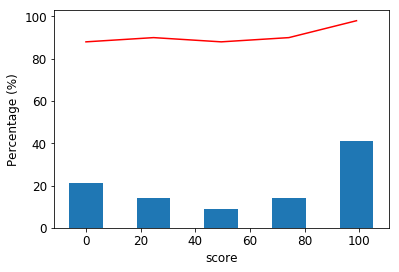

In [7]:
rupPred = RupturaPrediction(X)
rupPred.DESCONHECIDO = [0,0,1]
rupPred.addLastX(lastX)
rupPred.validate(Ytest, model)
dataScore = rupPred.calculateDataScore()  # passo que define a validacao
rupPred.plotScore(dataScore)

In [8]:
xnext = []
for xBatch, point in zip(X, lastX):
    #print(point)
    print(point.shape)
    xnext.append(np.append(xBatch,[point],axis=0))

(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)


(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)


In [10]:
lastX.shape

(3130, 3)

In [11]:
X.shape

(3130, 60, 3)

In [ ]:
pred = dataScore.score.tolist()
ytrue = dataScore.Inadimplente.tolist()
ytrue = [int(x) for x in ytrue]
modelIndicators = ModelIndicators(version)
modelIndicators.TARGET_SCORE_CUT = 30
modelIndicators.setPredProbs(ytrue,pred)
indic = modelIndicators.allIndicators()
file = open('ruptura-indicators.csv','a+')
file.write('\n' + 'version;' + version + ';' + 'referenceDate;' + referenceDate + '\n')
for i in range(len(indic)):
    file.write(str(indic.index[i]) + ';' + str(indic.iloc[i,0]) + '\n')
file.close()

# ESTATISTICA DESCRITIVA

In [ ]:
allT = [x.split('-') for x in createBatch.titles]
loja = []
prod = []
for t in allT:
    loja.append(t[0])
    prod.append(t[1])
nPontosDeVenda = len(collections.Counter(loja).keys())
nProdutos = len(collections.Counter(prod).keys())
xzao = []
for x in X:
    for xt in x:
        xzao.append(str(xt))
ocorrenciaCounter = collections.Counter(xzao)        